<a href="https://colab.research.google.com/github/samanehPahlavani/MscFraudDetection/blob/main/Model2_ML(RF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
try:
  import google.colab
  !{sys.executable} -m pip -q -q install pandas>=0.24.2
  !{sys.executable} -m pip -q -q install matplotlib>=3.0.3
  !{sys.executable} -m pip -q -q install seaborn>=0.9.1
  !{sys.executable} -m pip -q -q install numpy>=1.18.5
  !{sys.executable} -m pip -q -q install scikit-learn>=0.22.2
  !{sys.executable} -m pip -q -q install pycm>=2.2
except:
  pass


In [2]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import plot_tree

from sklearn.preprocessing import StandardScaler
from pycm import ConfusionMatrix, Compare



In [7]:
def LoadData():
  warnings.filterwarnings('ignore')
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  df = pd.read_csv(os.path.join("/content/drive/MyDrive/EtherFirstDataSet/", "3.csv"))
  return df

In [13]:
RANDOM_STATE = 23

def preprocess(df):
  positive_sample = df[df["Flag"] == 1]
  negative_sample = df[df["Flag"] == 0].sample(len(positive_sample), random_state = RANDOM_STATE)
  data = pd.concat([negative_sample, positive_sample], axis = 0)
  y = data["Flag"]
  X = data.iloc[:,2:]

  for col in X.columns:
      X[col] = X[col].fillna(X[col].mean())
  return X,y


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
df=LoadData()
X,y=preprocess(df)

### **Random Forest**

In [15]:
from sklearn.ensemble import RandomForestClassifier
FOLD_NUMBER = 10
METRIC_LIST = ["Accuracy", "F1", "Kappa", "Precision", "Recall"]



Random forests or random decision forests is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees.


**Parameters:**

In [16]:

rf_params = {"n_estimators": 150, "criterion": "entropy", "bootstrap": True}



Train

We will use 10-Folds cross-validator. Split dataset into 10 consecutive folds.

Each fold is then used once as a validation while the 9 remaining folds form the training set.


**Train**

In [17]:
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X, y)
kf = KFold(n_splits=10, random_state = RANDOM_STATE, shuffle=True)
cm_metric_list = []
rf_cm_worst = None
rf_cm_best = None
rf_cm_list = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test =  scaler.transform(X_test)
    rf_model.fit(X_train, y_train)
    cm = ConfusionMatrix(actual_vector = y_test.values, predict_vector = rf_model.predict(X_test))
    cm_metric_list.append({"Accuracy":cm.Overall_ACC, "F1": cm.F1[1], "Kappa": cm.Kappa, "Precision":cm.PPV[1]
                        , "Recall": cm.TPR[1]})
    cm.relabel({1: "Fraud", 0:"Non-Fraud"})
    rf_cm_list.append(cm)
    if rf_cm_worst is None:
        rf_cm_worst = cm
    else:
        if cm.Overall_ACC < rf_cm_worst.Overall_ACC:
            rf_cm_worst = cm

    if rf_cm_best is None:
        rf_cm_best = cm
    else:
        if cm.Overall_ACC > rf_cm_best.Overall_ACC:
            rf_cm_best = cm

**Performance**

Model Name: Random Forest Classifier

10-Fold Metrics: 

Accuracy : 0.89

F1 : 0.89

Kappa : 0.78

Precision : 0.89

Recall : 0.89



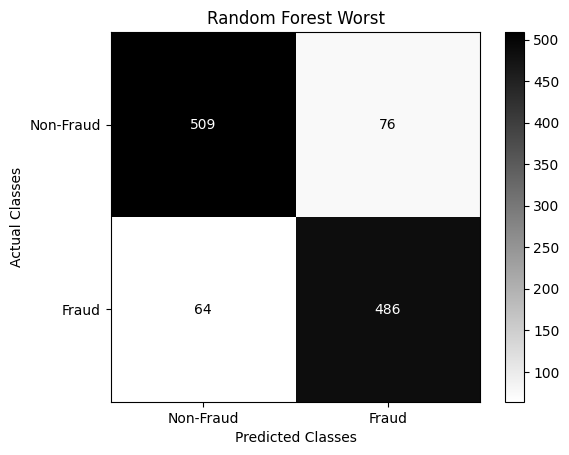

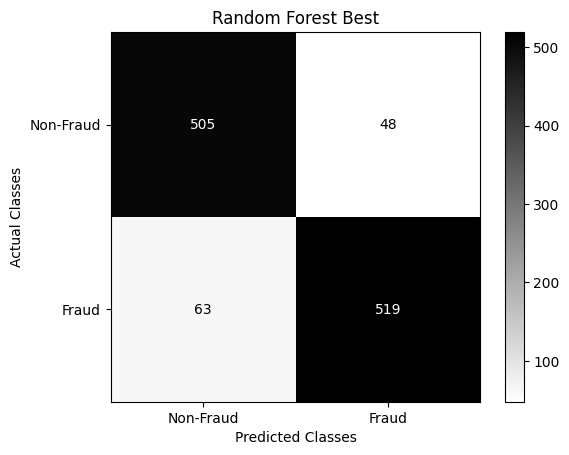

In [18]:


print("Model Name: Random Forest Classifier\n")
print("10-Fold Metrics: \n")
for metric in METRIC_LIST:
    temp = []
    for item in cm_metric_list:
        temp.append(item[metric])
    print("{0} : {1}\n".format(metric, np.mean(temp).round(2)))
rf_cm_worst.plot(title="Random Forest Worst", number_label=True)
rf_cm_best.plot(title="Random Forest Best", number_label=True)
plt.show()




Interpretation

Random Forest is an interpretable model and we can plot the trees and feature importances.


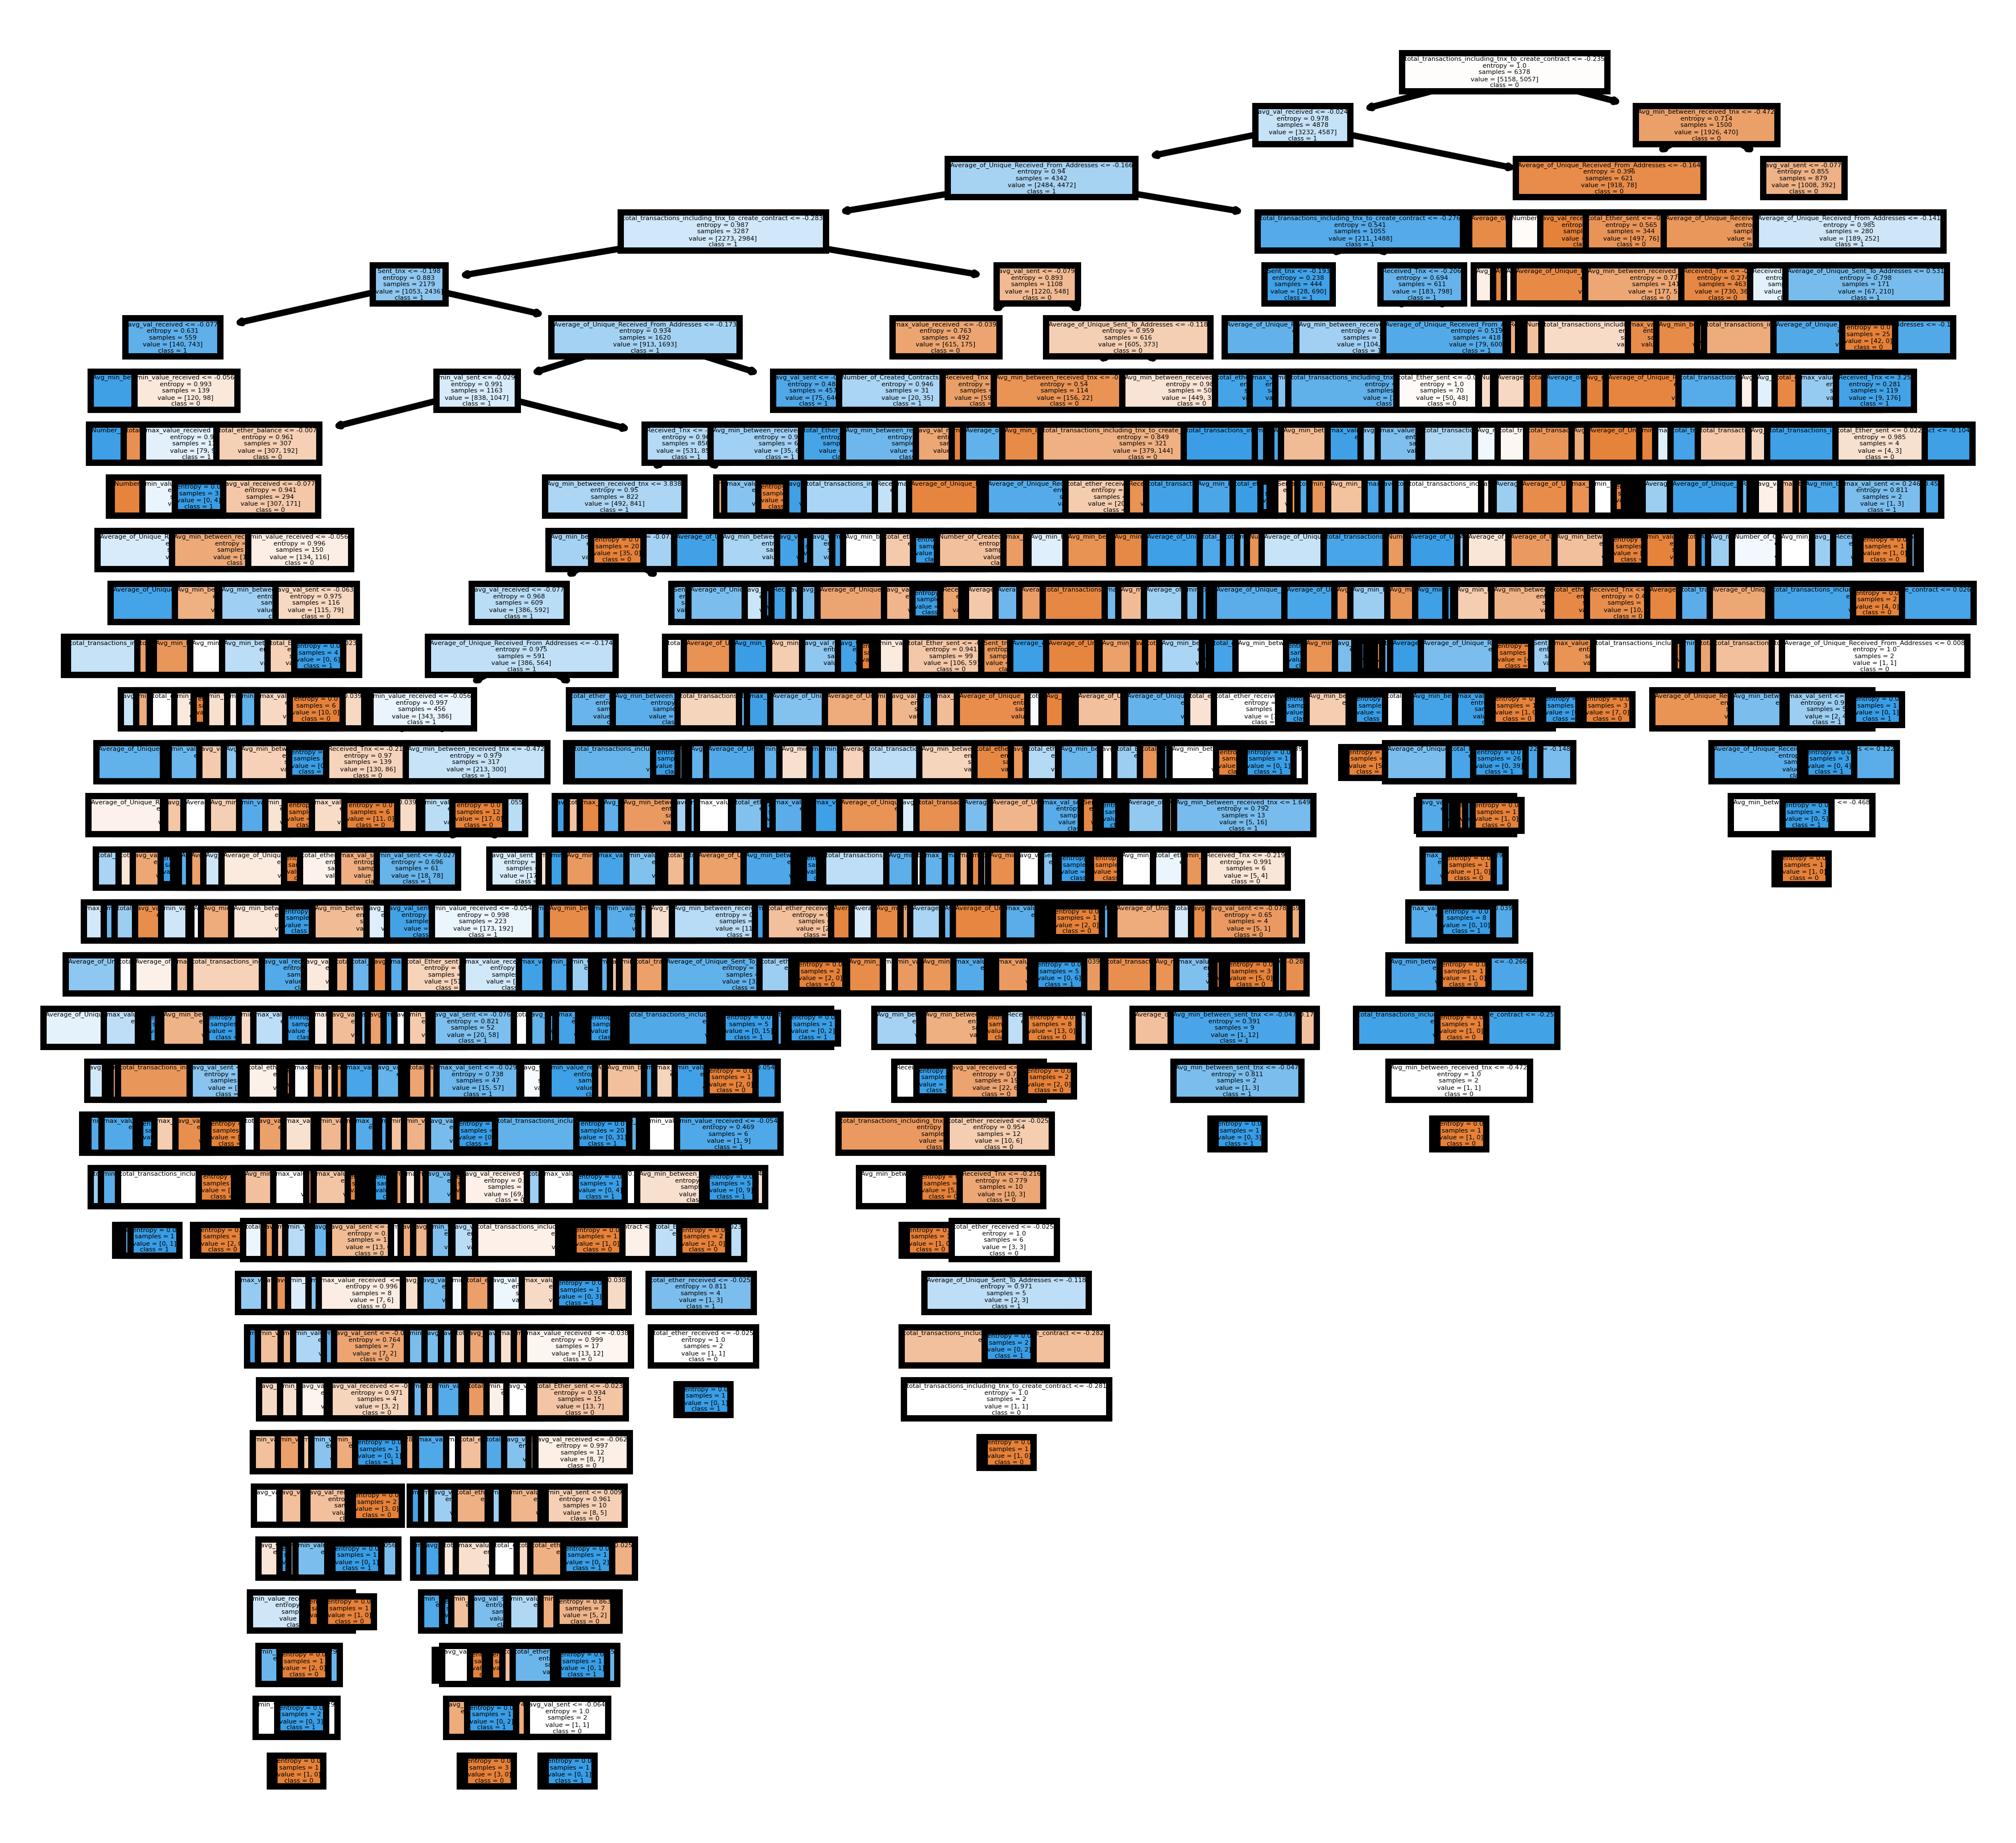

In [19]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=800)
plot_tree(rf_model.estimators_[0],
               feature_names = X.columns,
               class_names=["0","1"],
               filled = True);

In [20]:
len(rf_model.feature_importances_)

17

In [21]:
pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

Average_of_Unique_Received_From_Addresses              0.118584
Avg_min_between_received_tnx                           0.108692
total_transactions_including_tnx_to_create_contract    0.104740
avg_val_received                                       0.071502
Sent_tnx                                               0.069148
Received_Tnx                                           0.061521
avg_val_sent                                           0.060699
total_ether_received                                   0.055902
min_value_received                                     0.053819
max_val_sent                                           0.049334
Avg_min_between_sent_tnx                               0.047951
max_value_received                                     0.047520
min_val_sent                                           0.046293
total_Ether_sent                                       0.035564
total_ether_balance                                    0.031745
Average_of_Unique_Sent_To_Addresses     